**WELCOME TO PART II HACKERS**

> We will quickly introduce you to the various packages you will need to help you develop the Geographical Information System application/website/dashboard using Colab


---



1.   GEEMAP is a Python package for interactive geospatial analysis and visualization with Google Earth Engine (GEE), which is a cloud computing platform with a multi-petabyte catalog of satellite imagery and geospatial datasets. You will need to install it to interact with readily available satellite image data.




In [32]:
!pip install geemap

In [24]:
!pip install PyCRS

  Preparing metadata (setup.py) ... done
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=7bf436bb4e1f39835aefd9b15963b8003174ff08616e6e98a173dc4e83498463
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built PyCRS


In [7]:
import geemap

In [3]:
import ee

In [8]:
import os

In [9]:
import geopandas

In [10]:
from geemap import geojson_to_ee, ee_to_geojson


2.   Authentication with Earth Engine is required to connect your project with Earth Engine



Run the ee.Authenticate function to authenticate your access to Earth Engine servers and ee.Initialize to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. More at: https://developers.google.com/earth-engine/guides/python_install

In case ee.Initialize() is not running, you need to create your own cloud EE project and enable API direclty to allow Colab to use EE features through this link: https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup (follow the link on the section "Create a Cloud project" then proceed with the next section "Enable the Earth Engine API")

In [4]:
ee.Authenticate()

In [5]:
ee.Initialize (project='ee-joaomcosta')

Alternatively: Open GEE Code Editor https://code.earthengine.google.com/, set up your own project manually (set up a non commerciable project) and enable permission for the GEE APIs for Colab.


```
ee.Initialize (project='your project name')
```





---



Now let's start with basic vizualization process, first you will be asked to upload the batch of shapefiles provided to you in your local file folder in collab. The Brazil.shp file serves as the official country boundary of our area of interest.

In [25]:
brazil_shapefile = geemap.shp_to_ee('/content/Brazil.shp')

Identify the most fire prone areas

In [33]:
# Define the dataset and filter by date
dataset = ee.ImageCollection('MODIS/061/MCD64A1').filter(ee.Filter.date('2002-01-01', '2022-01-01'))
burnedArea = dataset.select('BurnDate')

# A FeatureCollection defining Brazil boundary.
fc = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(
    'country_na == "Brazil"'
)

# Clip the burned Area by the Brazil boundary FeatureCollection.
# Iterate over the ImageCollection and clip each image to the FeatureCollection.
ba_clip = burnedArea.map(lambda img: img.clipToCollection(fc))


# Visualization parameters
burnedAreaVis = {
    'min': 30.0,
    'max': 341.0,
    'palette': ['4e0400', '951003', 'c61503', 'ff1901']
}

# Create a map
Map = geemap.Map(center=[-10, -55], zoom=4)
# Add burned area layer to the map
Map.addLayer(ba_clip, burnedAreaVis, 'Burned Area')
Map.addLayer(brazil_shapefile, name='Brazil',opacity=0.5)
Map.addLayerControl()

# Display the map
Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [34]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the burn area dataset
dataset = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2002-01-01', '2022-12-31'))

# Create a binary ImageCollection where 1 indicates a burn date is present, and 0 where it isn't
burned = dataset.map(lambda image: image.select('BurnDate').gt(0).copyProperties(image, ['system:time_start']))

# Reduce the ImageCollection to a single Image, summing up the burn occurrences
summed = burned.sum()

# A FeatureCollection of Brazil states
brazil_states = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# Calculate the total burned area within each state
stats = summed.reduceRegions(
  collection = brazil_states,
  reducer = ee.Reducer.sum(),
  scale = 500
)

# Sort the states by burned area and get the top 5
top5_states = stats.sort('sum', False).limit(5)

# Print the names of the top 5 states
top5_info = top5_states.getInfo()

for feature in top5_info['features']:
    print(feature['properties']['ADM1_NAME'])

# Add the top 5 states with the most burn area to the map
Map = geemap.Map(center=[-15,-60], zoom=4)
Map.addLayer(top5_states, {}, 'Top 5 states with most burned area')
Map

Mato Grosso Do Sul
Mato Grosso
Tocantins
Tocantins
Mato Grosso


Map(center=[-15, -60], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

A different approach would be getting the likelihood of having a fire there.

In [14]:
Map = geemap.Map()

dataset = ee.ImageCollection("projects/climate-engine-pro/assets/ce-merra2_fwi-daily")
image = dataset.filterDate('2022-12-01', '2023-02-01').select('FWI').max()

vis_params = {
    'min': 0,
    'max': 50,
    'palette': ['green', 'yellow', 'orange', 'red'],
}

image = image.clip(brazil_shapefile)
Map.setCenter(-55, -10, 4)
Map.addLayer(image, vis_params, 'FWI')

# legend
legend_keys = ['Low', 'Medium', 'High']
gradient_colors = [(0, 255, 0), (255, 255, 0), (255, 0, 0)]  # RGB for green, yellow, red

# Define the title for the legend
legend_title = 'FWI'

# Add the gradient legend to the map
Map.add_legend(title=legend_title, keys=legend_keys, colors=gradient_colors, position='bottomright')

Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

Next, let's see how the land cover was in January 1st 2004 in Brazil using the MODIS MCD12Q1 Type 1 Land Cover

In [22]:
Map = geemap.Map()

landcover = ee.Image('MODIS/006/MCD12Q1/2004_01_01').select('LC_Type1')

igbpLandCoverVis = {
    'min': 1.0,
    'max': 17.0,
    'palette': [
        '05450a',
        '086a10',
        '54a708',
        '78d203',
        '009900',
        'c6b044',
        'dcd159',
        'dade48',
        'fbff13',
        'b6ff05',
        '27ff87',
        'c24f44',
        'a5a5a5',
        'ff6d4c',
        '69fff8',
        'f9ffa4',
        '1c0dff',
    ],
}
brazil_lc = landcover.clip(brazil_shapefile)
Map.setCenter(-55, -10, 4)
Map.addLayer(brazil_lc, igbpLandCoverVis, 'MODIS Land Cover')

Map

Map(center=[-10, -55], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [21]:
Map.add_legend(builtin_legend='MODIS/051/MCD12Q1')

Next, we can compute basic statistics of how much hectares of each LC type was in Brazil in 2004. This line will allow you to donwload the results in your colab directory

In [26]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
global_stats = os.path.join(out_dir, 'global_stats_sum.csv')

# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
geemap.zonal_statistics_by_group(
    landcover,
    brazil_shapefile,
    global_stats,
    statistics_type='SUM',
    denominator=1000000,
    decimal_places=2,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /root/Downloads/global_stats_sum.csv


Better: you can just count the number of pixel for each class. As a pixel for a MODIS image is 250 m x 250 m, the area for one class will be number of pixel x 250 x 250

Code to get the trend in land degradation

In [28]:
# Calculate pixel areas
array = [1,2,3,4,5,6,8,11]
bad = {}
fc = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(
    'country_na == "Brazil"'
)
for i in range(2003,2020):
  lc = ee.Image(f'MODIS/006/MCD12Q1/{i}_01_01').select('LC_Type1')
  areaImage = ee.Image.pixelArea().addBands(lc)
  # Reduce the region to get summed areas
  areas = areaImage.reduceRegion(
      reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
      geometry=fc.geometry(),
      scale=500,
      maxPixels=1e10
  )

  total_sum = sum(item['sum'] for item in areas.getInfo()['groups'])

  array_sum = sum(item['sum'] for item in areas.getInfo()['groups'] if item['class'] in array)

  bad[i] = total_sum - array_sum

slope: 2554593231.154908, intercept: -4046956186748.338867


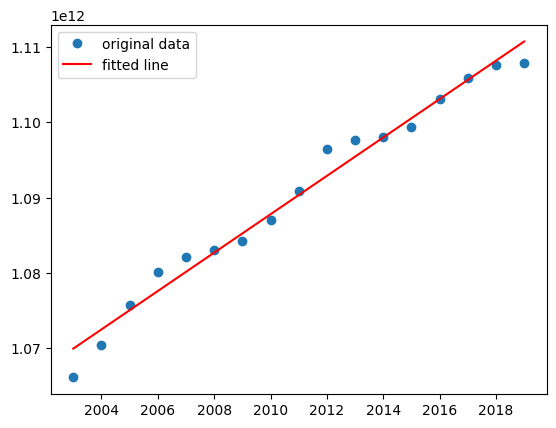

In [32]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Extract years and corresponding values from the dictionary
years = list(bad.keys())
values = list(bad.values())
values = [value * 0.5 * 0.5 for value in values]

# Calculate linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(years, values)
print("slope: %f, intercept: %f" % (slope, intercept))

# Plot the original data and the trend line
plt.plot(years, values, 'o', label='original data')
plt.plot(years, intercept + slope*np.array(years), 'r', label='fitted line')
plt.legend()
plt.show()

Identifying evidence about areas of threat. Ploting the protected areas of Brazil. Then searching for the deflorestation(white) and the fires(red) in the area.

In [16]:
# Create an Earth Engine map
Map = geemap.Map()

# Define the region of interest
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
brazil = countries.filter(ee.Filter.eq('country_na', 'Brazil'))

dataset = ee.ImageCollection('MODIS/061/MCD64A1').filter(ee.Filter.date('2017-01-01', '2018-05-01'))

burnedArea = dataset.select('BurnDate')

# Define the dataset of world's protected areas
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Plotting the protected locations over Brazil
brazil_protected_areas = protected_areas.filterBounds(brazil)
brazil_burnedArea = burnedArea.map(lambda img: img.clip(brazil))

forest_loss = ee.Image('UMD/hansen/global_forest_change_2020_v1_8').select('loss').clip(brazil_protected_areas)

burnedAreaVis = {'min': 30.0, 'max': 3413.0, 'palette': ['red', 'orange', 'yellow'], 'opacity':0.8}
Map.addLayer(brazil_burnedArea.mean(), burnedAreaVis, 'Burned Area')

forest_loss_viz = {'min': 0, 'max': 1, 'palette': ['white', 'red'],'opacity':0.8}

# Add forest change layer
Map.addLayer(forest_loss, forest_loss_viz, "Forest Loss")

# Center the map over Brazil
Map.centerObject(brazil,4)

# Display the map
Map

Map(center=[-10.62529999009238, -53.20696469939302], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
# Create an Earth Engine map
Map = geemap.Map()

# Define the region of interest, which is Brazil
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
brazil = countries.filter(ee.Filter.eq('country_na', 'Brazil'))

burnedArea = dataset.select('BurnDate')

# Clip the burned Area by the Brazil boundary FeatureCollection.
# Iterate over the ImageCollection and clip each image to the FeatureCollection.

# Define the dataset of world's protected areas
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')


# Add change in NDVI to map
Map.addLayer(brazil, {}, 'Protected Areas')

protected_areas_in_brazil = protected_areas.filterBounds(brazil.geometry())
ba_clip = burnedArea.map(lambda img: img.clipToCollection(protected_areas_in_brazil))
forest_loss = ee.Image('UMD/hansen/global_forest_change_2020_v1_8').select('loss').clip(protected_areas_in_brazil)

Map.addLayer(protected_areas_in_brazil, {}, 'Protected Areas in Brazil')
burnedAreaVis = {'min': 30.0, 'max': 3413.0, 'palette': ['red', 'orange', 'yellow'], 'opacity':0.8}
Map.addLayer(ba_clip.mean(), burnedAreaVis, 'Burned Area')

forest_loss_viz = {'min': 0, 'max': 1, 'palette': ['green', 'red'],'opacity':0.8}

# Add forest change layer
Map.addLayer(forest_loss, forest_loss_viz, "Forest Loss")

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [18]:
import ee
import geemap

# Initialize the Earth Engine
ee.Initialize()

# Create a map
map = geemap.Map()

# Load Brazil's regions
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
brazil = countries.filter(ee.Filter.eq('country_na', 'Brazil'))

# Load Protected areas
protected_areas = ee.FeatureCollection('WCMC/WDPA/current/polygons')
brazil_protected_areas = brazil_protected_areas.map(lambda
    feature: feature.intersection(brazil))

# Filter protected areas in Brazil
brazil_protected_areas = protected_areas.filterBounds(brazil)

# Get the Global Forest Change dataset
gfc2020 = ee.Image('UMD/hansen/global_forest_change_2020_v1_8')
# Load the MODIS/061/MCD64A1 collection
fire_dataset = ee.ImageCollection('MODIS/061/MCD64A1').filter(ee.Filter.date('2017-01-01', '2018-05-01'))

# Select the 'lossyear' band and clip to Brazil's protected areas
mask = ee.Image().byte().paint(brazil_protected_areas, 1)
forest_loss = gfc2020.select('lossyear').updateMask(mask)
burnedArea = fire_dataset.select('BurnDate').mean().updateMask(mask)

# Define the visualization parameters for forest loss.
forest_loss_vis = {
  'bands': ['lossyear'],
  'min': 20.0,
  'max': 20.0,
  'palette': ['green', 'green']
}


# Select the 'BurnDate' band and clip to Brazil's protected areas

fire_palette = ['FF0000']  # red

burnedArea_vis = {
    'min': 30.0,
    'max': 500.0,
    'palette': fire_palette
}

# Add the deforestation layer to the map
map.addLayer(forest_loss, forest_loss_vis, 'Deforestation in Protected Areas')
map.addLayer(brazil_protected_areas, {}, 'Protected Areas in Brazil')

# Add fire data to the map
map.addLayer(burnedArea, burnedArea_vis, 'Fire Data')

# Set map center
map.setCenter(-53, -15, 4)

# Display the map
map

Map(center=[-15, -53], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

Population affected directly by the fires.

In [35]:
# Set the dates
start_of_2020 = '2002-01-01'
end_of_2020 = '2022-12-31'

# Filter FAO country data to get Brazil
brazil_shapefile = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# Get the geometry of Brazil
brazil_geometry = brazil_shapefile.geometry()

# Get the fire data
fire = (ee.ImageCollection('MODIS/006/MCD64A1')
        .filter(ee.Filter.date(start_of_2020, end_of_2020))).max()

# Get the population data
population = (ee.ImageCollection('WorldPop/GP/100m/pop')
              .filter(ee.Filter.date(start_of_2020, end_of_2020)).mean())

# Clip datasets to Brazil
fire = fire.clip(brazil_geometry)
population = population.clip(brazil_geometry)

# Create a binary mask of the 'BurnDate' band indicating whether a wildfire occurred
fire_mask_partial = fire.select('BurnDate').gt(0)

# Use 'where' to assign population counts to burn areas
fire_mask_full = ee.Image.constant(0).where(fire_mask_partial, 1)
pop_affected = population.where(fire_mask_full.Not(), 0)

# Clip affected population to Brazil
pop_affected = pop_affected.clip(brazil_geometry)

# Reduce the population affected within Brazil
total_pop_affected = pop_affected.reduceRegion(reducer=ee.Reducer.sum(), geometry=brazil_geometry, scale=100, maxPixels=1e10)

# To get result print this line:
# print('Total affected population:', total_pop_affected.getInfo())

# Visualize
Map = geemap.Map()

# Visualize population in Brazil
vis_params = {
  'min': 1,
  'max': 100,  # change this to your actual max value
  'palette': ['ffffff', '000000']
}

# Visualize population affected by fires
Map.addLayer(pop_affected, vis_params, 'Population affected in Brazil')

# Center map over Brazil
Map.centerObject(brazil_geometry, 5)

Map.addLayerControl()
Map

Map(center=[-10.613275552794567, -53.19823757236853], controls=(WidgetControl(options=['position', 'transparen…

this was the code to get by state and the information of all the population affected by the fires. Unfortunatly, our google colab reached the maximum computational units and we can't run it in under 5 minutes.

In [ ]:
# Total burned area
total_burned_area = fire_mask_partial.reduceRegion(reducer=ee.Reducer.sum(), geometry=brazil_geometry, scale=100, maxPixels=1e10)
# Obtain result
result = total_burned_area.getInfo()
print('Total burned aread by wildfires in 2020: ', result['BurnDate'] * 0.5 * 0.5, 'km^2')

In [ ]:
start_of_2020 = '2020-01-01'
end_of_2020 = '2020-12-31'

# Get Brazil geometry
brazil_shapefile = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
brazil_geometry = brazil_shapefile.geometry()

# Get the fire data (filtered to Brazil)
fire = (ee.ImageCollection('MODIS/006/MCD64A1')
        .filterBounds(brazil_geometry)
        .filter(ee.Filter.date(start_of_2020, end_of_2020))).max()

# Get the population data (filtered to Brazil)
population = (ee.ImageCollection('WorldPop/GP/100m/pop')
              .filterBounds(brazil_geometry)
              .filter(ee.Filter.date(start_of_2020, end_of_2020))).mean()

# Create a binary mask of the 'BurnDate' band indicating whether a wildfire occurred
fire_mask_partial = fire.select('BurnDate').gt(0)

# Use 'where' to assign population counts to burn areas
fire_mask_full = ee.Image.constant(0).where(fire_mask_partial, 1)
pop_affected = population.where(fire_mask_full.Not(), 0)

# FeatureCollection of Brazil states
brazil_states = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))

# Map the reduceRegion function over the states feature collection to get the affected population in each state
affected_pop_stats = brazil_states.map(lambda feature: feature.set(
    pop_affected.reduceRegion(ee.Reducer.sum(), feature.geometry(), 100, maxPixels=1e13)))

# Sort the feature collection by population affected and get the state with most affected population
most_affected_state = affected_pop_stats.sort('sum', False).first()

# Print the state with the most affected population
print('Most affected state:', most_affected_state.get('ADM1_NAME').getInfo())
print('Affected population:', most_affected_state.get('sum').getInfo())

# Get the sum of all affected population
total_pop_affected = affected_pop_stats.reduceColumns(ee.Reducer.sum(), selectors=['sum'])

# Print the total number of people affected
print("Total affected population in Brazil:", total_pop_affected.getInfo())

# Create a map
Map = geemap.Map(center=[-15,-60], zoom=4)

# Add the state with the most affected population to the map
Map.addLayer(ee.FeatureCollection([most_affected_state]), {}, 'State with most affected population')

# Show map
Map